In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
#import math
import random
#import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
#from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 5
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0

local = 11

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  60000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 11

global_epoch = 0
acc, loss = 0, 0
cluster_acc, cluster_loss, Cluster_ACC, Cluster_LOSS = [], [], [], [] 
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
        TMP_w.extend(TMP_b) ##append 말고 더해야함..

        TMP_w = np.array(TMP_w)
        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    kmeans_model_w = KMeans(n_clusters=3)   # 0, 1은 silhouette 에 안먹힘  

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 3  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 

    # ==========> 클러스터 갯수 정해짐


    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(3): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):
            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['L{}_layer{}_w'.format(i,layer_index)][0] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][0])
                globals()['L{}_layer{}_w'.format(i,layer_index)][1] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][1])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])

#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0
Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비

# Weight, bias 합친 것
 # FedAvg                   :  G{}_w_layer
 # 일반 클러스터링          :  G{}_c{}_w_layer{}               클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w
 # Actiavtion + 클러스터링  :  G{}_c{}_w_layer{}_Act           클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w_c_a



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4642 - accuracy: 0.8230
32/32 - 0s - loss: 0.4473 - accuracy: 0.8360
32/32 - 0s - loss: 0.5013 - accuracy: 0.8270
32/32 - 0s - loss: 0.5020 - accuracy: 0.8180
32/32 - 0s - loss: 0.4798 - accuracy: 0.8140
32/32 - 0s - loss: 0.4566 - accuracy: 0.8360
32/32 - 0s - loss: 0.5365 - accuracy: 0.8080
32/32 - 0s - loss: 0.5015 - accuracy: 0.8080
32/32 - 0s - loss: 0.3939 - accuracy: 0.8580
32/32 - 0s - loss: 0.4909 - accuracy: 0.8280
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time :  99.7421064376831 




<ipython-input-7-1216f49a350e>:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
<ipython-input-7-1216f49a350e>:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(glob

In [8]:
G_epoch = 101

for global_epoch in range(1, G_epoch):

    for i in range(1, local):
        if global_epoch == 1:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)
        else:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['G{}_c_L{}_model'.format(global_epoch-1, i)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
    
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언
                    
                  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

    for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        best_Sil_score_c = []
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []
        
        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
            
        for i in range(1, local):
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
            TMP_w.extend(TMP_b) ##append 말고 더해야함..

            TMP_w = np.array(TMP_w)
            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        kmeans_model_w = KMeans(n_clusters=3)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])

        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 3  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
        

        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(3): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                    globals()['L{}_layer{}_w'.format(i,layer_index)][0] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][0])
                    globals()['L{}_layer{}_w'.format(i,layer_index)][1] = np.tanh(globals()['L{}_layer{}_w'.format(i,layer_index)][1])
                    
                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

        
        sum_for_var_w,sum_for_var_b = 0, 0
        for sps in range(3):
            sum_for_var_w = sum_for_var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][0]
            sum_for_var_b = sum_for_var_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][1] 
        
        sum_for_var_w = sum_for_var_w/(3)
        sum_for_var_b = sum_for_var_b/(3)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(sum_for_var_w))
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(sum_for_var_b))
  

        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])


    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4855 - accuracy: 0.8290
32/32 - 0s - loss: 0.5087 - accuracy: 0.8140
32/32 - 0s - loss: 0.4541 - accuracy: 0.8380
32/32 - 0s - loss: 0.5457 - accuracy: 0.7870
32/32 - 0s - loss: 0.4691 - accuracy: 0.8240
32/32 - 0s - loss: 0.4512 - accuracy: 0.8240
32/32 - 0s - loss: 0.4847 - accuracy: 0.8170
32/32 - 0s - loss: 0.5649 - accuracy: 0.7900
32/32 - 0s - loss: 0.5134 - accuracy: 0.8110
32/32 - 0s - loss: 0.5011 - accuracy: 0.8040
------------    1  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  95.49620962142944 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


2  번째 global_epoch 데이터 랜덤하게 준비!!
2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4596 - accuracy: 0.8310
32/32 - 0s - loss: 0.4593 - accuracy: 0.8340
32/32 - 0s - loss: 0.3999 - accuracy: 0.8530
32/32 - 0s - loss: 0.4779 - accuracy: 0.8170
32/32 - 0s - loss: 0.4805 - accuracy: 0.8160
32/32 - 0s - loss: 0.3940 - accuracy: 0.8600
32/32 - 0s - loss: 0.4690 - accuracy: 0.8300
32/32 - 0s - loss: 0.4735 - accuracy: 0.8200
32/32 - 0s - loss: 0.5216 - accuracy: 0.8240
32/32 - 0s - loss: 0.4931 - accuracy: 0.8230
------------    2  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  95.91376757621765 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


3  번째 global_epoch 데이터 랜덤하게 준비!!
3  번째 global_epoch 데이터 랜덤 준비완료!!


3  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3685 - accuracy: 0.8620
32/32 - 0s - loss: 0.4674 - accuracy: 0.8250
32/32 - 0s - loss: 0.3570 - accuracy: 0.8740
32/32 - 0s - loss: 0.4216 - accuracy: 0.8590
32/32 - 0s - loss: 0.4170 - accuracy: 0.8490
32/32 - 0s - loss: 0.4919 - accuracy: 0.8230
32/32 - 0s - loss: 0.4335 - accuracy: 0.8520
32/32 - 0s - loss: 0.4525 - accuracy: 0.8340
32/32 - 0s - loss: 0.4598 - accuracy: 0.8220
32/32 - 0s - loss: 0.4585 - accuracy: 0.8360
------------    3  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  95.5373923778534 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


4  번째 global_epoch 데이터 랜덤하게 준비!!
4  번째 global_epoch 데이터 랜덤 준비완료!!


4  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3526 - accuracy: 0.8850
32/32 - 0s - loss: 0.4563 - accuracy: 0.8270
32/32 - 0s - loss: 0.3521 - accuracy: 0.8700
32/32 - 0s - loss: 0.4173 - accuracy: 0.8500
32/32 - 0s - loss: 0.3924 - accuracy: 0.8570
32/32 - 0s - loss: 0.4687 - accuracy: 0.8520
32/32 - 0s - loss: 0.4084 - accuracy: 0.8580
32/32 - 0s - loss: 0.5195 - accuracy: 0.8280
32/32 - 0s - loss: 0.4244 - accuracy: 0.8470
32/32 - 0s - loss: 0.3949 - accuracy: 0.8700
------------    4  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  95.43329739570618 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!
5  번째 global_epoch 데이터 랜덤 준비완료!!


5  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4177 - accuracy: 0.8440
32/32 - 0s - loss: 0.4107 - accuracy: 0.8470
32/32 - 0s - loss: 0.3844 - accuracy: 0.8730
32/32 - 0s - loss: 0.4262 - accuracy: 0.8390
32/32 - 0s - loss: 0.4013 - accuracy: 0.8520
32/32 - 0s - loss: 0.4185 - accuracy: 0.8760
32/32 - 0s - loss: 0.4622 - accuracy: 0.8540
32/32 - 0s - loss: 0.4475 - accuracy: 0.8320
32/32 - 0s - loss: 0.3786 - accuracy: 0.8680
32/32 - 0s - loss: 0.3573 - accuracy: 0.8780
------------    5  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  95.96879982948303 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


6  번째 global_epoch 데이터 랜덤하게 준비!!
6  번째 global_epoch 데이터 랜덤 준비완료!!


6  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3978 - accuracy: 0.8650
32/32 - 0s - loss: 0.3483 - accuracy: 0.8690
32/32 - 0s - loss: 0.3713 - accuracy: 0.8790
32/32 - 0s - loss: 0.3573 - accuracy: 0.8810
32/32 - 0s - loss: 0.3322 - accuracy: 0.8850
32/32 - 0s - loss: 0.4613 - accuracy: 0.8620
32/32 - 0s - loss: 0.4134 - accuracy: 0.8650
32/32 - 0s - loss: 0.3926 - accuracy: 0.8670
32/32 - 0s - loss: 0.4120 - accuracy: 0.8500
32/32 - 0s - loss: 0.3841 - accuracy: 0.8680
------------    6  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  95.81126570701599 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


7  번째 global_epoch 데이터 랜덤하게 준비!!
7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4570 - accuracy: 0.8440
32/32 - 0s - loss: 0.4111 - accuracy: 0.8690
32/32 - 0s - loss: 0.3850 - accuracy: 0.8830
32/32 - 0s - loss: 0.3891 - accuracy: 0.8720
32/32 - 0s - loss: 0.3520 - accuracy: 0.8710
32/32 - 0s - loss: 0.3852 - accuracy: 0.8750
32/32 - 0s - loss: 0.3932 - accuracy: 0.8700
32/32 - 0s - loss: 0.4540 - accuracy: 0.8330
32/32 - 0s - loss: 0.3652 - accuracy: 0.8820
32/32 - 0s - loss: 0.3721 - accuracy: 0.8700
------------    7  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  96.7301139831543 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


8  번째 global_epoch 데이터 랜덤하게 준비!!
8  번째 global_epoch 데이터 랜덤 준비완료!!


8  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4162 - accuracy: 0.8630
32/32 - 0s - loss: 0.3915 - accuracy: 0.8740
32/32 - 0s - loss: 0.3426 - accuracy: 0.8730
32/32 - 0s - loss: 0.3777 - accuracy: 0.8670
32/32 - 0s - loss: 0.3557 - accuracy: 0.8750
32/32 - 0s - loss: 0.3936 - accuracy: 0.8610
32/32 - 0s - loss: 0.4643 - accuracy: 0.8540
32/32 - 0s - loss: 0.3880 - accuracy: 0.8650
32/32 - 0s - loss: 0.3613 - accuracy: 0.8750
32/32 - 0s - loss: 0.4410 - accuracy: 0.8650
------------    8  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  97.41910362243652 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!
9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3987 - accuracy: 0.8730
32/32 - 0s - loss: 0.3581 - accuracy: 0.8770
32/32 - 0s - loss: 0.3267 - accuracy: 0.8870
32/32 - 0s - loss: 0.4061 - accuracy: 0.8760
32/32 - 0s - loss: 0.3384 - accuracy: 0.8880
32/32 - 0s - loss: 0.3464 - accuracy: 0.8790
32/32 - 0s - loss: 0.3465 - accuracy: 0.8860
32/32 - 0s - loss: 0.4568 - accuracy: 0.8610
32/32 - 0s - loss: 0.3888 - accuracy: 0.8730
32/32 - 0s - loss: 0.3904 - accuracy: 0.8670
------------    9  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  97.05122423171997 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


10  번째 global_epoch 데이터 랜덤하게 준비!!
10  번째 global_epoch 데이터 랜덤 준비완료!!


10  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3273 - accuracy: 0.9040
32/32 - 0s - loss: 0.4366 - accuracy: 0.8760
32/32 - 0s - loss: 0.3657 - accuracy: 0.8940
32/32 - 0s - loss: 0.3926 - accuracy: 0.8720
32/32 - 0s - loss: 0.3356 - accuracy: 0.8830
32/32 - 0s - loss: 0.3906 - accuracy: 0.8850
32/32 - 0s - loss: 0.4077 - accuracy: 0.8610
32/32 - 0s - loss: 0.3832 - accuracy: 0.8860
32/32 - 0s - loss: 0.3779 - accuracy: 0.8930
32/32 - 0s - loss: 0.3952 - accuracy: 0.8730
------------    10  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  98.86681747436523 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


11  번째 global_epoch 데이터 랜덤하게 준비!!
11  번째 global_epoch 데이터 랜덤 준비완료!!


11  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3440 - accuracy: 0.8820
32/32 - 0s - loss: 0.3768 - accuracy: 0.8970
32/32 - 0s - loss: 0.4060 - accuracy: 0.8870
32/32 - 0s - loss: 0.3627 - accuracy: 0.8850
32/32 - 0s - loss: 0.3716 - accuracy: 0.8850
32/32 - 0s - loss: 0.3953 - accuracy: 0.8830
32/32 - 0s - loss: 0.4350 - accuracy: 0.8600
32/32 - 0s - loss: 0.3776 - accuracy: 0.8820
32/32 - 0s - loss: 0.3865 - accuracy: 0.8700
32/32 - 0s - loss: 0.3685 - accuracy: 0.8880
------------    11  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  99.94853901863098 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


12  번째 global_epoch 데이터 랜덤하게 준비!!
12  번째 global_epoch 데이터 랜덤 준비완료!!


12  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3601 - accuracy: 0.8740
32/32 - 0s - loss: 0.4899 - accuracy: 0.8650
32/32 - 0s - loss: 0.3576 - accuracy: 0.8950
32/32 - 0s - loss: 0.3129 - accuracy: 0.9000
32/32 - 0s - loss: 0.4240 - accuracy: 0.8830
32/32 - 0s - loss: 0.4678 - accuracy: 0.8660
32/32 - 0s - loss: 0.3517 - accuracy: 0.8900
32/32 - 0s - loss: 0.3243 - accuracy: 0.8890
32/32 - 0s - loss: 0.3556 - accuracy: 0.8860
32/32 - 0s - loss: 0.3971 - accuracy: 0.8800
------------    12  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  101.06015491485596 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!
13  번째 global_epoch 데이터 랜덤 준비완료!!


13  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4863 - accuracy: 0.8620
32/32 - 0s - loss: 0.4010 - accuracy: 0.8720
32/32 - 0s - loss: 0.3732 - accuracy: 0.8940
32/32 - 0s - loss: 0.4443 - accuracy: 0.8650
32/32 - 0s - loss: 0.4086 - accuracy: 0.8840
32/32 - 0s - loss: 0.3515 - accuracy: 0.8900
32/32 - 0s - loss: 0.3818 - accuracy: 0.8770
32/32 - 0s - loss: 0.3907 - accuracy: 0.8770
32/32 - 0s - loss: 0.3859 - accuracy: 0.8900
32/32 - 0s - loss: 0.4431 - accuracy: 0.8830
------------    13  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  101.69751477241516 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


14  번째 global_epoch 데이터 랜덤하게 준비!!
14  번째 global_epoch 데이터 랜덤 준비완료!!


14  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4249 - accuracy: 0.8710
32/32 - 0s - loss: 0.3527 - accuracy: 0.8850
32/32 - 0s - loss: 0.3983 - accuracy: 0.9030
32/32 - 0s - loss: 0.3121 - accuracy: 0.8900
32/32 - 0s - loss: 0.3523 - accuracy: 0.8820
32/32 - 0s - loss: 0.4032 - accuracy: 0.8770
32/32 - 0s - loss: 0.4610 - accuracy: 0.8880
32/32 - 0s - loss: 0.3721 - accuracy: 0.8830
32/32 - 0s - loss: 0.4301 - accuracy: 0.8650
32/32 - 0s - loss: 0.3807 - accuracy: 0.8880
------------    14  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  105.20763349533081 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3826 - accuracy: 0.8800
32/32 - 0s - loss: 0.3935 - accuracy: 0.8890
32/32 - 0s - loss: 0.3697 - accuracy: 0.8910
32/32 - 0s - loss: 0.4241 - accuracy: 0.8800
32/32 - 0s - loss: 0.3871 - accuracy: 0.8900
32/32 - 0s - loss: 0.4368 - accuracy: 0.8770
32/32 - 0s - loss: 0.3899 - accuracy: 0.8960
32/32 - 0s - loss: 0.3771 - accuracy: 0.8850
32/32 - 0s - loss: 0.3900 - accuracy: 0.8900
32/32 - 0s - loss: 0.4073 - accuracy: 0.8740
------------    15  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  108.06853413581848 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


16  번째 global_epoch 데이터 랜덤하게 준비!!
16  번째 global_epoch 데이터 랜덤 준비완료!!


16  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3890 - accuracy: 0.8770
32/32 - 0s - loss: 0.4199 - accuracy: 0.8700
32/32 - 0s - loss: 0.4409 - accuracy: 0.8870
32/32 - 0s - loss: 0.3862 - accuracy: 0.8960
32/32 - 0s - loss: 0.3480 - accuracy: 0.8990
32/32 - 0s - loss: 0.4523 - accuracy: 0.8820
32/32 - 0s - loss: 0.3528 - accuracy: 0.8940
32/32 - 0s - loss: 0.3524 - accuracy: 0.8870
32/32 - 0s - loss: 0.4230 - accuracy: 0.8760
32/32 - 0s - loss: 0.3905 - accuracy: 0.8810
------------    16  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  108.14113116264343 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


17  번째 global_epoch 데이터 랜덤하게 준비!!
17  번째 global_epoch 데이터 랜덤 준비완료!!


17  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4101 - accuracy: 0.8720
32/32 - 0s - loss: 0.3646 - accuracy: 0.9050
32/32 - 0s - loss: 0.4529 - accuracy: 0.8940
32/32 - 0s - loss: 0.4024 - accuracy: 0.8960
32/32 - 0s - loss: 0.5049 - accuracy: 0.8820
32/32 - 0s - loss: 0.4263 - accuracy: 0.8660
32/32 - 0s - loss: 0.3939 - accuracy: 0.8860
32/32 - 0s - loss: 0.3671 - accuracy: 0.8780
32/32 - 0s - loss: 0.3958 - accuracy: 0.8820
32/32 - 0s - loss: 0.4468 - accuracy: 0.8860
------------    17  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  110.03785562515259 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


18  번째 global_epoch 데이터 랜덤하게 준비!!
18  번째 global_epoch 데이터 랜덤 준비완료!!


18  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3872 - accuracy: 0.8970
32/32 - 0s - loss: 0.4020 - accuracy: 0.8980
32/32 - 0s - loss: 0.4700 - accuracy: 0.8830
32/32 - 0s - loss: 0.4136 - accuracy: 0.8900
32/32 - 0s - loss: 0.3365 - accuracy: 0.8990
32/32 - 0s - loss: 0.5525 - accuracy: 0.8780
32/32 - 0s - loss: 0.4146 - accuracy: 0.8820
32/32 - 0s - loss: 0.4644 - accuracy: 0.8910
32/32 - 0s - loss: 0.4613 - accuracy: 0.8710
32/32 - 0s - loss: 0.5291 - accuracy: 0.8720
------------    18  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  110.34572291374207 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


19  번째 global_epoch 데이터 랜덤하게 준비!!
19  번째 global_epoch 데이터 랜덤 준비완료!!


19  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4554 - accuracy: 0.8760
32/32 - 0s - loss: 0.4166 - accuracy: 0.8780
32/32 - 0s - loss: 0.4004 - accuracy: 0.8820
32/32 - 0s - loss: 0.3846 - accuracy: 0.8940
32/32 - 0s - loss: 0.4368 - accuracy: 0.8900
32/32 - 0s - loss: 0.4058 - accuracy: 0.8860
32/32 - 0s - loss: 0.3654 - accuracy: 0.8900
32/32 - 0s - loss: 0.3118 - accuracy: 0.9040
32/32 - 0s - loss: 0.4112 - accuracy: 0.8830
32/32 - 0s - loss: 0.4146 - accuracy: 0.8950
------------    19  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  110.87547659873962 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


20  번째 global_epoch 데이터 랜덤하게 준비!!
20  번째 global_epoch 데이터 랜덤 준비완료!!


20  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.3386 - accuracy: 0.8940
32/32 - 0s - loss: 0.3093 - accuracy: 0.9100
32/32 - 0s - loss: 0.4873 - accuracy: 0.8850
32/32 - 0s - loss: 0.4135 - accuracy: 0.9040
32/32 - 0s - loss: 0.5364 - accuracy: 0.8780
32/32 - 0s - loss: 0.4158 - accuracy: 0.8710
32/32 - 0s - loss: 0.3762 - accuracy: 0.9000
32/32 - 0s - loss: 0.4033 - accuracy: 0.8920
32/32 - 0s - loss: 0.4955 - accuracy: 0.8720
32/32 - 0s - loss: 0.4392 - accuracy: 0.8830
------------    20  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  109.29457402229309 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!
21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5108 - accuracy: 0.8720
32/32 - 0s - loss: 0.3369 - accuracy: 0.9100
32/32 - 0s - loss: 0.5005 - accuracy: 0.8820
32/32 - 0s - loss: 0.4081 - accuracy: 0.9000
32/32 - 0s - loss: 0.4280 - accuracy: 0.8960
32/32 - 0s - loss: 0.4277 - accuracy: 0.8880
32/32 - 0s - loss: 0.4157 - accuracy: 0.8960
32/32 - 0s - loss: 0.4444 - accuracy: 0.8860
32/32 - 0s - loss: 0.4221 - accuracy: 0.8870
32/32 - 0s - loss: 0.4670 - accuracy: 0.8700
------------    21  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  111.10550808906555 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


22  번째 global_epoch 데이터 랜덤하게 준비!!
22  번째 global_epoch 데이터 랜덤 준비완료!!


22  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4057 - accuracy: 0.8770
32/32 - 0s - loss: 0.4848 - accuracy: 0.8700
32/32 - 0s - loss: 0.5081 - accuracy: 0.8740
32/32 - 0s - loss: 0.3712 - accuracy: 0.8870
32/32 - 0s - loss: 0.4389 - accuracy: 0.8950
32/32 - 0s - loss: 0.4419 - accuracy: 0.8850
32/32 - 0s - loss: 0.4502 - accuracy: 0.8890
32/32 - 0s - loss: 0.4541 - accuracy: 0.8890
32/32 - 0s - loss: 0.3928 - accuracy: 0.9040
32/32 - 0s - loss: 0.4155 - accuracy: 0.8910
------------    22  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  110.8301420211792 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


23  번째 global_epoch 데이터 랜덤하게 준비!!
23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4662 - accuracy: 0.8740
32/32 - 0s - loss: 0.4806 - accuracy: 0.8700
32/32 - 0s - loss: 0.4862 - accuracy: 0.9100
32/32 - 0s - loss: 0.5482 - accuracy: 0.8850
32/32 - 0s - loss: 0.3833 - accuracy: 0.8910
32/32 - 0s - loss: 0.4682 - accuracy: 0.8990
32/32 - 0s - loss: 0.4152 - accuracy: 0.8950
32/32 - 0s - loss: 0.3888 - accuracy: 0.8920
32/32 - 0s - loss: 0.5283 - accuracy: 0.8710
32/32 - 0s - loss: 0.5064 - accuracy: 0.8980
------------    23  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  110.75677347183228 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


24  번째 global_epoch 데이터 랜덤하게 준비!!
24  번째 global_epoch 데이터 랜덤 준비완료!!


24  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5154 - accuracy: 0.8740
32/32 - 0s - loss: 0.4427 - accuracy: 0.8900
32/32 - 0s - loss: 0.4545 - accuracy: 0.8930
32/32 - 0s - loss: 0.4566 - accuracy: 0.8910
32/32 - 0s - loss: 0.4765 - accuracy: 0.8940
32/32 - 0s - loss: 0.5433 - accuracy: 0.8820
32/32 - 0s - loss: 0.4556 - accuracy: 0.8980
32/32 - 0s - loss: 0.5454 - accuracy: 0.8970
32/32 - 0s - loss: 0.4178 - accuracy: 0.9030
32/32 - 0s - loss: 0.4815 - accuracy: 0.8700
------------    24  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  111.7372829914093 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


25  번째 global_epoch 데이터 랜덤하게 준비!!
25  번째 global_epoch 데이터 랜덤 준비완료!!


25  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4154 - accuracy: 0.8890
32/32 - 0s - loss: 0.3535 - accuracy: 0.9050
32/32 - 0s - loss: 0.5571 - accuracy: 0.8910
32/32 - 0s - loss: 0.4999 - accuracy: 0.8920
32/32 - 0s - loss: 0.4556 - accuracy: 0.8820
32/32 - 0s - loss: 0.4813 - accuracy: 0.8930
32/32 - 0s - loss: 0.3776 - accuracy: 0.8960
32/32 - 0s - loss: 0.4298 - accuracy: 0.8970
32/32 - 0s - loss: 0.4025 - accuracy: 0.9010
32/32 - 0s - loss: 0.4176 - accuracy: 0.9010
------------    25  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  113.91379857063293 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


26  번째 global_epoch 데이터 랜덤하게 준비!!
26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4083 - accuracy: 0.8870
32/32 - 0s - loss: 0.4098 - accuracy: 0.9040
32/32 - 0s - loss: 0.5362 - accuracy: 0.8760
32/32 - 0s - loss: 0.5056 - accuracy: 0.8860
32/32 - 0s - loss: 0.4963 - accuracy: 0.8880
32/32 - 0s - loss: 0.5071 - accuracy: 0.8910
32/32 - 0s - loss: 0.4201 - accuracy: 0.9050
32/32 - 0s - loss: 0.4633 - accuracy: 0.8890
32/32 - 0s - loss: 0.5100 - accuracy: 0.8810
32/32 - 0s - loss: 0.4267 - accuracy: 0.8960
------------    26  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  115.35502195358276 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


27  번째 global_epoch 데이터 랜덤하게 준비!!
27  번째 global_epoch 데이터 랜덤 준비완료!!


27  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5126 - accuracy: 0.8680
32/32 - 0s - loss: 0.4338 - accuracy: 0.8960
32/32 - 0s - loss: 0.5858 - accuracy: 0.8720
32/32 - 0s - loss: 0.5758 - accuracy: 0.8780
32/32 - 0s - loss: 0.4419 - accuracy: 0.8930
32/32 - 0s - loss: 0.4979 - accuracy: 0.8930
32/32 - 0s - loss: 0.4763 - accuracy: 0.8800
32/32 - 0s - loss: 0.4494 - accuracy: 0.8840
32/32 - 0s - loss: 0.3831 - accuracy: 0.8980
32/32 - 0s - loss: 0.4880 - accuracy: 0.8930
------------    27  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  116.50974655151367 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!
28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4539 - accuracy: 0.8790
32/32 - 0s - loss: 0.4864 - accuracy: 0.8920
32/32 - 0s - loss: 0.5306 - accuracy: 0.8970
32/32 - 0s - loss: 0.5636 - accuracy: 0.8870
32/32 - 0s - loss: 0.4767 - accuracy: 0.8830
32/32 - 0s - loss: 0.4116 - accuracy: 0.9040
32/32 - 0s - loss: 0.5369 - accuracy: 0.8890
32/32 - 0s - loss: 0.5138 - accuracy: 0.8870
32/32 - 0s - loss: 0.4449 - accuracy: 0.8980
32/32 - 0s - loss: 0.4989 - accuracy: 0.8890
------------    28  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  117.76478552818298 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


29  번째 global_epoch 데이터 랜덤하게 준비!!
29  번째 global_epoch 데이터 랜덤 준비완료!!


29  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4721 - accuracy: 0.8910
32/32 - 0s - loss: 0.5497 - accuracy: 0.8870
32/32 - 0s - loss: 0.6022 - accuracy: 0.8840
32/32 - 0s - loss: 0.4258 - accuracy: 0.8990
32/32 - 0s - loss: 0.4648 - accuracy: 0.9010
32/32 - 0s - loss: 0.5801 - accuracy: 0.8760
32/32 - 0s - loss: 0.5179 - accuracy: 0.8870
32/32 - 0s - loss: 0.4121 - accuracy: 0.9010
32/32 - 0s - loss: 0.4305 - accuracy: 0.9010
32/32 - 0s - loss: 0.5371 - accuracy: 0.8870
------------    29  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  124.05584979057312 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


30  번째 global_epoch 데이터 랜덤하게 준비!!
30  번째 global_epoch 데이터 랜덤 준비완료!!


30  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5777 - accuracy: 0.8640
32/32 - 0s - loss: 0.4915 - accuracy: 0.9010
32/32 - 0s - loss: 0.5363 - accuracy: 0.8970
32/32 - 0s - loss: 0.5128 - accuracy: 0.8880
32/32 - 0s - loss: 0.4946 - accuracy: 0.8990
32/32 - 0s - loss: 0.4841 - accuracy: 0.8840
32/32 - 0s - loss: 0.6465 - accuracy: 0.8620
32/32 - 0s - loss: 0.4819 - accuracy: 0.8910
32/32 - 0s - loss: 0.4041 - accuracy: 0.8950
32/32 - 0s - loss: 0.3946 - accuracy: 0.9090
------------    30  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  120.67359900474548 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


31  번째 global_epoch 데이터 랜덤하게 준비!!
31  번째 global_epoch 데이터 랜덤 준비완료!!


31  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5482 - accuracy: 0.8720
32/32 - 0s - loss: 0.4910 - accuracy: 0.8930
32/32 - 0s - loss: 0.4548 - accuracy: 0.9010
32/32 - 0s - loss: 0.5164 - accuracy: 0.8800
32/32 - 0s - loss: 0.6726 - accuracy: 0.8820
32/32 - 0s - loss: 0.5604 - accuracy: 0.8840
32/32 - 0s - loss: 0.4703 - accuracy: 0.8910
32/32 - 0s - loss: 0.4841 - accuracy: 0.9040
32/32 - 0s - loss: 0.5871 - accuracy: 0.8790
32/32 - 0s - loss: 0.5734 - accuracy: 0.8830
------------    31  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  121.44272780418396 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


32  번째 global_epoch 데이터 랜덤하게 준비!!
32  번째 global_epoch 데이터 랜덤 준비완료!!


32  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5435 - accuracy: 0.8680
32/32 - 0s - loss: 0.3925 - accuracy: 0.9080
32/32 - 0s - loss: 0.5259 - accuracy: 0.8840
32/32 - 0s - loss: 0.5496 - accuracy: 0.8970
32/32 - 0s - loss: 0.5471 - accuracy: 0.8850
32/32 - 0s - loss: 0.4927 - accuracy: 0.8830
32/32 - 0s - loss: 0.4936 - accuracy: 0.8940
32/32 - 0s - loss: 0.5468 - accuracy: 0.8870
32/32 - 0s - loss: 0.5485 - accuracy: 0.8860
32/32 - 0s - loss: 0.5307 - accuracy: 0.8910
------------    32  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  131.3646318912506 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


33  번째 global_epoch 데이터 랜덤하게 준비!!
33  번째 global_epoch 데이터 랜덤 준비완료!!


33  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4567 - accuracy: 0.8850
32/32 - 0s - loss: 0.3992 - accuracy: 0.9000
32/32 - 0s - loss: 0.5629 - accuracy: 0.8940
32/32 - 0s - loss: 0.4383 - accuracy: 0.9050
32/32 - 0s - loss: 0.5427 - accuracy: 0.8910
32/32 - 0s - loss: 0.6063 - accuracy: 0.8860
32/32 - 0s - loss: 0.4577 - accuracy: 0.9000
32/32 - 0s - loss: 0.5008 - accuracy: 0.8850
32/32 - 0s - loss: 0.4071 - accuracy: 0.8880
32/32 - 0s - loss: 0.4736 - accuracy: 0.8980
------------    33  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  139.6318962574005 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!
34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4001 - accuracy: 0.8940
32/32 - 0s - loss: 0.5407 - accuracy: 0.8860
32/32 - 0s - loss: 0.5992 - accuracy: 0.8840
32/32 - 0s - loss: 0.4210 - accuracy: 0.9110
32/32 - 0s - loss: 0.6333 - accuracy: 0.8780
32/32 - 0s - loss: 0.4544 - accuracy: 0.8860
32/32 - 0s - loss: 0.5555 - accuracy: 0.8950
32/32 - 0s - loss: 0.3843 - accuracy: 0.9060
32/32 - 0s - loss: 0.4895 - accuracy: 0.8830
32/32 - 0s - loss: 0.4795 - accuracy: 0.9030
------------    34  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  140.6704866886139 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


35  번째 global_epoch 데이터 랜덤하게 준비!!
35  번째 global_epoch 데이터 랜덤 준비완료!!


35  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4279 - accuracy: 0.8760
32/32 - 0s - loss: 0.5231 - accuracy: 0.9030
32/32 - 0s - loss: 0.6015 - accuracy: 0.8920
32/32 - 0s - loss: 0.4507 - accuracy: 0.9010
32/32 - 0s - loss: 0.4321 - accuracy: 0.9080
32/32 - 0s - loss: 0.5429 - accuracy: 0.8930
32/32 - 0s - loss: 0.4946 - accuracy: 0.8930
32/32 - 0s - loss: 0.5847 - accuracy: 0.8800
32/32 - 0s - loss: 0.4300 - accuracy: 0.9080
32/32 - 0s - loss: 0.5290 - accuracy: 0.8920
------------    35  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  145.10190963745117 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


36  번째 global_epoch 데이터 랜덤하게 준비!!
36  번째 global_epoch 데이터 랜덤 준비완료!!


36  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5994 - accuracy: 0.8800
32/32 - 0s - loss: 0.6082 - accuracy: 0.8780
32/32 - 0s - loss: 0.4235 - accuracy: 0.9020
32/32 - 0s - loss: 0.5033 - accuracy: 0.9040
32/32 - 0s - loss: 0.5403 - accuracy: 0.8950
32/32 - 0s - loss: 0.5191 - accuracy: 0.8940
32/32 - 0s - loss: 0.5004 - accuracy: 0.8840
32/32 - 0s - loss: 0.4872 - accuracy: 0.8920
32/32 - 0s - loss: 0.6183 - accuracy: 0.8900
32/32 - 0s - loss: 0.4406 - accuracy: 0.9140
------------    36  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  144.73743438720703 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


37  번째 global_epoch 데이터 랜덤하게 준비!!
37  번째 global_epoch 데이터 랜덤 준비완료!!


37  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6117 - accuracy: 0.8760
32/32 - 0s - loss: 0.5851 - accuracy: 0.8870
32/32 - 0s - loss: 0.5434 - accuracy: 0.8850
32/32 - 0s - loss: 0.5296 - accuracy: 0.8860
32/32 - 0s - loss: 0.4762 - accuracy: 0.9100
32/32 - 0s - loss: 0.5281 - accuracy: 0.8890
32/32 - 0s - loss: 0.4795 - accuracy: 0.8990
32/32 - 0s - loss: 0.4694 - accuracy: 0.8980
32/32 - 0s - loss: 0.5131 - accuracy: 0.9010
32/32 - 0s - loss: 0.4846 - accuracy: 0.8960
------------    37  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  143.78370785713196 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


38  번째 global_epoch 데이터 랜덤하게 준비!!
38  번째 global_epoch 데이터 랜덤 준비완료!!


38  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6305 - accuracy: 0.8770
32/32 - 0s - loss: 0.5844 - accuracy: 0.9010
32/32 - 0s - loss: 0.4566 - accuracy: 0.9070
32/32 - 0s - loss: 0.4550 - accuracy: 0.8960
32/32 - 0s - loss: 0.5238 - accuracy: 0.9060
32/32 - 0s - loss: 0.5352 - accuracy: 0.8850
32/32 - 0s - loss: 0.4273 - accuracy: 0.9160
32/32 - 0s - loss: 0.6306 - accuracy: 0.8710
32/32 - 0s - loss: 0.4867 - accuracy: 0.8980
32/32 - 0s - loss: 0.4959 - accuracy: 0.8890
------------    38  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  149.12228512763977 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


39  번째 global_epoch 데이터 랜덤하게 준비!!
39  번째 global_epoch 데이터 랜덤 준비완료!!


39  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4338 - accuracy: 0.8870
32/32 - 0s - loss: 0.5775 - accuracy: 0.8940
32/32 - 0s - loss: 0.4499 - accuracy: 0.9100
32/32 - 0s - loss: 0.5704 - accuracy: 0.8960
32/32 - 0s - loss: 0.6734 - accuracy: 0.8870
32/32 - 0s - loss: 0.4737 - accuracy: 0.9070
32/32 - 0s - loss: 0.5342 - accuracy: 0.8880
32/32 - 0s - loss: 0.4123 - accuracy: 0.9120
32/32 - 0s - loss: 0.5983 - accuracy: 0.8970
32/32 - 0s - loss: 0.5738 - accuracy: 0.8910
------------    39  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  148.94609570503235 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


40  번째 global_epoch 데이터 랜덤하게 준비!!
40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4665 - accuracy: 0.8820
32/32 - 0s - loss: 0.6199 - accuracy: 0.8960
32/32 - 0s - loss: 0.5099 - accuracy: 0.9160
32/32 - 0s - loss: 0.4709 - accuracy: 0.8990
32/32 - 0s - loss: 0.4797 - accuracy: 0.9030
32/32 - 0s - loss: 0.5486 - accuracy: 0.8980
32/32 - 0s - loss: 0.6581 - accuracy: 0.8830
32/32 - 0s - loss: 0.4804 - accuracy: 0.9140
32/32 - 0s - loss: 0.5499 - accuracy: 0.8980
32/32 - 0s - loss: 0.4624 - accuracy: 0.8930
------------    40  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  149.17876529693604 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


41  번째 global_epoch 데이터 랜덤하게 준비!!
41  번째 global_epoch 데이터 랜덤 준비완료!!


41  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4475 - accuracy: 0.8960
32/32 - 0s - loss: 0.4689 - accuracy: 0.8980
32/32 - 0s - loss: 0.5532 - accuracy: 0.8930
32/32 - 0s - loss: 0.5061 - accuracy: 0.8990
32/32 - 0s - loss: 0.4923 - accuracy: 0.9020
32/32 - 0s - loss: 0.4127 - accuracy: 0.9150
32/32 - 0s - loss: 0.5221 - accuracy: 0.8950
32/32 - 0s - loss: 0.4410 - accuracy: 0.9110
32/32 - 0s - loss: 0.5229 - accuracy: 0.8970
32/32 - 0s - loss: 0.6978 - accuracy: 0.8710
------------    41  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  149.88296270370483 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


42  번째 global_epoch 데이터 랜덤하게 준비!!
42  번째 global_epoch 데이터 랜덤 준비완료!!


42  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4674 - accuracy: 0.9020
32/32 - 0s - loss: 0.5007 - accuracy: 0.9160
32/32 - 0s - loss: 0.5868 - accuracy: 0.8910
32/32 - 0s - loss: 0.5308 - accuracy: 0.8990
32/32 - 0s - loss: 0.5046 - accuracy: 0.9060
32/32 - 0s - loss: 0.4894 - accuracy: 0.8930
32/32 - 0s - loss: 0.4559 - accuracy: 0.8900
32/32 - 0s - loss: 0.5996 - accuracy: 0.8980
32/32 - 0s - loss: 0.5100 - accuracy: 0.9040
32/32 - 0s - loss: 0.5357 - accuracy: 0.8920
------------    42  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  150.43038988113403 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


43  번째 global_epoch 데이터 랜덤하게 준비!!
43  번째 global_epoch 데이터 랜덤 준비완료!!


43  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4860 - accuracy: 0.8830
32/32 - 0s - loss: 0.4956 - accuracy: 0.9240
32/32 - 0s - loss: 0.6014 - accuracy: 0.8840
32/32 - 0s - loss: 0.6363 - accuracy: 0.8960
32/32 - 0s - loss: 0.5143 - accuracy: 0.9080
32/32 - 0s - loss: 0.5947 - accuracy: 0.8910
32/32 - 0s - loss: 0.5929 - accuracy: 0.8900
32/32 - 0s - loss: 0.5567 - accuracy: 0.8840
32/32 - 0s - loss: 0.4920 - accuracy: 0.8900
32/32 - 0s - loss: 0.5993 - accuracy: 0.8970
------------    43  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  153.84216690063477 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


44  번째 global_epoch 데이터 랜덤하게 준비!!
44  번째 global_epoch 데이터 랜덤 준비완료!!


44  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5538 - accuracy: 0.8750
32/32 - 0s - loss: 0.5095 - accuracy: 0.8960
32/32 - 0s - loss: 0.6077 - accuracy: 0.9000
32/32 - 0s - loss: 0.4714 - accuracy: 0.9030
32/32 - 0s - loss: 0.6481 - accuracy: 0.8880
32/32 - 0s - loss: 0.6103 - accuracy: 0.8930
32/32 - 0s - loss: 0.5544 - accuracy: 0.8740
32/32 - 0s - loss: 0.4532 - accuracy: 0.9140
32/32 - 0s - loss: 0.5213 - accuracy: 0.9050
32/32 - 0s - loss: 0.5527 - accuracy: 0.9020
------------    44  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  157.76724123954773 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


45  번째 global_epoch 데이터 랜덤하게 준비!!
45  번째 global_epoch 데이터 랜덤 준비완료!!


45  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6028 - accuracy: 0.8780
32/32 - 0s - loss: 0.5122 - accuracy: 0.9040
32/32 - 0s - loss: 0.6399 - accuracy: 0.8960
32/32 - 0s - loss: 0.5453 - accuracy: 0.9080
32/32 - 0s - loss: 0.7033 - accuracy: 0.8910
32/32 - 0s - loss: 0.4994 - accuracy: 0.9010
32/32 - 0s - loss: 0.5843 - accuracy: 0.8940
32/32 - 0s - loss: 0.4674 - accuracy: 0.9010
32/32 - 0s - loss: 0.6245 - accuracy: 0.8950
32/32 - 0s - loss: 0.6141 - accuracy: 0.9010
------------    45  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  157.42479133605957 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


46  번째 global_epoch 데이터 랜덤하게 준비!!
46  번째 global_epoch 데이터 랜덤 준비완료!!


46  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5637 - accuracy: 0.8990
32/32 - 0s - loss: 0.5675 - accuracy: 0.8880
32/32 - 0s - loss: 0.6374 - accuracy: 0.8930
32/32 - 0s - loss: 0.4829 - accuracy: 0.9070
32/32 - 0s - loss: 0.6401 - accuracy: 0.8960
32/32 - 0s - loss: 0.5670 - accuracy: 0.9100
32/32 - 0s - loss: 0.5652 - accuracy: 0.8970
32/32 - 0s - loss: 0.4838 - accuracy: 0.9050
32/32 - 0s - loss: 0.7299 - accuracy: 0.8840
32/32 - 0s - loss: 0.5034 - accuracy: 0.9120
------------    46  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  159.75866627693176 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


47  번째 global_epoch 데이터 랜덤하게 준비!!
47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5289 - accuracy: 0.8810
32/32 - 0s - loss: 0.4476 - accuracy: 0.8940
32/32 - 0s - loss: 0.6047 - accuracy: 0.8920
32/32 - 0s - loss: 0.6131 - accuracy: 0.8970
32/32 - 0s - loss: 0.5988 - accuracy: 0.9030
32/32 - 0s - loss: 0.4898 - accuracy: 0.8940
32/32 - 0s - loss: 0.5164 - accuracy: 0.8980
32/32 - 0s - loss: 0.6217 - accuracy: 0.8970
32/32 - 0s - loss: 0.5066 - accuracy: 0.9060
32/32 - 0s - loss: 0.8050 - accuracy: 0.8750
------------    47  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  160.7361078262329 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


48  번째 global_epoch 데이터 랜덤하게 준비!!
48  번째 global_epoch 데이터 랜덤 준비완료!!


48  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5551 - accuracy: 0.8780
32/32 - 0s - loss: 0.5228 - accuracy: 0.8930
32/32 - 0s - loss: 0.5796 - accuracy: 0.8930
32/32 - 0s - loss: 0.4457 - accuracy: 0.9220
32/32 - 0s - loss: 0.6325 - accuracy: 0.9010
32/32 - 0s - loss: 0.6526 - accuracy: 0.8790
32/32 - 0s - loss: 0.4617 - accuracy: 0.9040
32/32 - 0s - loss: 0.5349 - accuracy: 0.9060
32/32 - 0s - loss: 0.4255 - accuracy: 0.9200
32/32 - 0s - loss: 0.5109 - accuracy: 0.8970
------------    48  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  161.43180394172668 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


49  번째 global_epoch 데이터 랜덤하게 준비!!
49  번째 global_epoch 데이터 랜덤 준비완료!!


49  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5188 - accuracy: 0.8930
32/32 - 0s - loss: 0.4750 - accuracy: 0.9120
32/32 - 0s - loss: 0.6107 - accuracy: 0.8940
32/32 - 0s - loss: 0.5244 - accuracy: 0.9070
32/32 - 0s - loss: 0.6322 - accuracy: 0.9010
32/32 - 0s - loss: 0.6600 - accuracy: 0.8850
32/32 - 0s - loss: 0.5063 - accuracy: 0.8950
32/32 - 0s - loss: 0.7077 - accuracy: 0.8910
32/32 - 0s - loss: 0.5132 - accuracy: 0.9040
32/32 - 0s - loss: 0.7219 - accuracy: 0.8860
------------    49  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  161.6029872894287 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


50  번째 global_epoch 데이터 랜덤하게 준비!!
50  번째 global_epoch 데이터 랜덤 준비완료!!


50  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5341 - accuracy: 0.8860
32/32 - 0s - loss: 0.5575 - accuracy: 0.8880
32/32 - 0s - loss: 0.5640 - accuracy: 0.9020
32/32 - 0s - loss: 0.7732 - accuracy: 0.8890
32/32 - 0s - loss: 0.6590 - accuracy: 0.9030
32/32 - 0s - loss: 0.5697 - accuracy: 0.8940
32/32 - 0s - loss: 0.6308 - accuracy: 0.8910
32/32 - 0s - loss: 0.5277 - accuracy: 0.8970
32/32 - 0s - loss: 0.6862 - accuracy: 0.8890
32/32 - 0s - loss: 0.5344 - accuracy: 0.9110
------------    50  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  162.43211722373962 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


51  번째 global_epoch 데이터 랜덤하게 준비!!
51  번째 global_epoch 데이터 랜덤 준비완료!!


51  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5867 - accuracy: 0.8720
32/32 - 0s - loss: 0.6184 - accuracy: 0.9030
32/32 - 0s - loss: 0.5824 - accuracy: 0.9050
32/32 - 0s - loss: 0.6197 - accuracy: 0.8920
32/32 - 0s - loss: 0.6445 - accuracy: 0.8940
32/32 - 0s - loss: 0.6823 - accuracy: 0.8790
32/32 - 0s - loss: 0.5057 - accuracy: 0.8910
32/32 - 0s - loss: 0.5185 - accuracy: 0.9060
32/32 - 0s - loss: 0.5133 - accuracy: 0.9140
32/32 - 0s - loss: 0.5852 - accuracy: 0.8950
------------    51  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  167.68644499778748 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


52  번째 global_epoch 데이터 랜덤하게 준비!!
52  번째 global_epoch 데이터 랜덤 준비완료!!


52  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5531 - accuracy: 0.8870
32/32 - 0s - loss: 0.6554 - accuracy: 0.8890
32/32 - 0s - loss: 0.5506 - accuracy: 0.8950
32/32 - 0s - loss: 0.5510 - accuracy: 0.9110
32/32 - 0s - loss: 0.5373 - accuracy: 0.9090
32/32 - 0s - loss: 0.6054 - accuracy: 0.8880
32/32 - 0s - loss: 0.6153 - accuracy: 0.8960
32/32 - 0s - loss: 0.5213 - accuracy: 0.8980
32/32 - 0s - loss: 0.6414 - accuracy: 0.8990
32/32 - 0s - loss: 0.5578 - accuracy: 0.8980
------------    52  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  169.79572916030884 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


53  번째 global_epoch 데이터 랜덤하게 준비!!
53  번째 global_epoch 데이터 랜덤 준비완료!!


53  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.7011 - accuracy: 0.8730
32/32 - 0s - loss: 0.6094 - accuracy: 0.9110
32/32 - 0s - loss: 0.6156 - accuracy: 0.8970
32/32 - 0s - loss: 0.5287 - accuracy: 0.9070
32/32 - 0s - loss: 0.7402 - accuracy: 0.8900
32/32 - 0s - loss: 0.6378 - accuracy: 0.8910
32/32 - 0s - loss: 0.7107 - accuracy: 0.8900
32/32 - 0s - loss: 0.4931 - accuracy: 0.9080
32/32 - 0s - loss: 0.6105 - accuracy: 0.8940
32/32 - 0s - loss: 0.6050 - accuracy: 0.8990
------------    53  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  175.75102996826172 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


54  번째 global_epoch 데이터 랜덤하게 준비!!
54  번째 global_epoch 데이터 랜덤 준비완료!!


54  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5042 - accuracy: 0.8950
32/32 - 0s - loss: 0.5815 - accuracy: 0.9110
32/32 - 0s - loss: 0.5776 - accuracy: 0.8970
32/32 - 0s - loss: 0.5552 - accuracy: 0.8940
32/32 - 0s - loss: 0.7088 - accuracy: 0.8940
32/32 - 0s - loss: 0.5945 - accuracy: 0.8880
32/32 - 0s - loss: 0.5924 - accuracy: 0.9010
32/32 - 0s - loss: 0.6142 - accuracy: 0.9010
32/32 - 0s - loss: 0.4346 - accuracy: 0.9170
32/32 - 0s - loss: 0.5655 - accuracy: 0.9060
------------    54  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  168.60055232048035 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


55  번째 global_epoch 데이터 랜덤하게 준비!!
55  번째 global_epoch 데이터 랜덤 준비완료!!


55  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5791 - accuracy: 0.8870
32/32 - 0s - loss: 0.5436 - accuracy: 0.9070
32/32 - 0s - loss: 0.6153 - accuracy: 0.8860
32/32 - 0s - loss: 0.7161 - accuracy: 0.8950
32/32 - 0s - loss: 0.6122 - accuracy: 0.9010
32/32 - 0s - loss: 0.7225 - accuracy: 0.8770
32/32 - 0s - loss: 0.6280 - accuracy: 0.8940
32/32 - 0s - loss: 0.6104 - accuracy: 0.8860
32/32 - 0s - loss: 0.6981 - accuracy: 0.8910
32/32 - 0s - loss: 0.5589 - accuracy: 0.8930
------------    55  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  169.84064555168152 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


56  번째 global_epoch 데이터 랜덤하게 준비!!
56  번째 global_epoch 데이터 랜덤 준비완료!!


56  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6152 - accuracy: 0.8930
32/32 - 0s - loss: 0.6427 - accuracy: 0.9070
32/32 - 0s - loss: 0.6905 - accuracy: 0.8870
32/32 - 0s - loss: 0.5688 - accuracy: 0.9120
32/32 - 0s - loss: 0.7005 - accuracy: 0.8940
32/32 - 0s - loss: 0.5199 - accuracy: 0.8910
32/32 - 0s - loss: 0.5508 - accuracy: 0.9130
32/32 - 0s - loss: 0.5625 - accuracy: 0.9010
32/32 - 0s - loss: 0.5082 - accuracy: 0.9050
32/32 - 0s - loss: 0.6611 - accuracy: 0.8970
------------    56  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  174.6604700088501 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


57  번째 global_epoch 데이터 랜덤하게 준비!!
57  번째 global_epoch 데이터 랜덤 준비완료!!


57  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6308 - accuracy: 0.8950
32/32 - 0s - loss: 0.6303 - accuracy: 0.9060
32/32 - 0s - loss: 0.4358 - accuracy: 0.9080
32/32 - 0s - loss: 0.6098 - accuracy: 0.8970
32/32 - 0s - loss: 0.5756 - accuracy: 0.9130
32/32 - 0s - loss: 0.6257 - accuracy: 0.8950
32/32 - 0s - loss: 0.4021 - accuracy: 0.9270
32/32 - 0s - loss: 0.4862 - accuracy: 0.9030
32/32 - 0s - loss: 0.6285 - accuracy: 0.9010
32/32 - 0s - loss: 0.5128 - accuracy: 0.9070
------------    57  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  174.69434475898743 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


58  번째 global_epoch 데이터 랜덤하게 준비!!
58  번째 global_epoch 데이터 랜덤 준비완료!!


58  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5396 - accuracy: 0.8950
32/32 - 0s - loss: 0.7357 - accuracy: 0.8890
32/32 - 0s - loss: 0.5872 - accuracy: 0.8920
32/32 - 0s - loss: 0.6784 - accuracy: 0.8990
32/32 - 0s - loss: 0.7077 - accuracy: 0.8980
32/32 - 0s - loss: 0.5992 - accuracy: 0.8850
32/32 - 0s - loss: 0.5861 - accuracy: 0.9040
32/32 - 0s - loss: 0.5370 - accuracy: 0.9170
32/32 - 0s - loss: 0.6231 - accuracy: 0.8910
32/32 - 0s - loss: 0.6527 - accuracy: 0.8960
------------    58  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  176.71213841438293 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


59  번째 global_epoch 데이터 랜덤하게 준비!!
59  번째 global_epoch 데이터 랜덤 준비완료!!


59  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5213 - accuracy: 0.8890
32/32 - 0s - loss: 0.4988 - accuracy: 0.9080
32/32 - 0s - loss: 0.4679 - accuracy: 0.9190
32/32 - 0s - loss: 0.8324 - accuracy: 0.8990
32/32 - 0s - loss: 0.7271 - accuracy: 0.9010
32/32 - 0s - loss: 0.5751 - accuracy: 0.8910
32/32 - 0s - loss: 0.7282 - accuracy: 0.8740
32/32 - 0s - loss: 0.6556 - accuracy: 0.8940
32/32 - 0s - loss: 0.7036 - accuracy: 0.8950
32/32 - 0s - loss: 0.5167 - accuracy: 0.9040
------------    59  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  180.89214372634888 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


60  번째 global_epoch 데이터 랜덤하게 준비!!
60  번째 global_epoch 데이터 랜덤 준비완료!!


60  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5282 - accuracy: 0.8850
32/32 - 0s - loss: 0.6878 - accuracy: 0.8930
32/32 - 0s - loss: 0.6548 - accuracy: 0.9050
32/32 - 0s - loss: 0.6973 - accuracy: 0.8900
32/32 - 0s - loss: 0.5490 - accuracy: 0.9150
32/32 - 0s - loss: 0.6299 - accuracy: 0.8870
32/32 - 0s - loss: 0.6123 - accuracy: 0.9050
32/32 - 0s - loss: 0.7017 - accuracy: 0.8850
32/32 - 0s - loss: 0.6283 - accuracy: 0.8800
32/32 - 0s - loss: 0.6075 - accuracy: 0.8980
------------    60  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  182.42998933792114 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


61  번째 global_epoch 데이터 랜덤하게 준비!!
61  번째 global_epoch 데이터 랜덤 준비완료!!


61  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6235 - accuracy: 0.8780
32/32 - 0s - loss: 0.5984 - accuracy: 0.9000
32/32 - 0s - loss: 0.5552 - accuracy: 0.8970
32/32 - 0s - loss: 0.6027 - accuracy: 0.8860
32/32 - 0s - loss: 0.7191 - accuracy: 0.8860
32/32 - 0s - loss: 0.7324 - accuracy: 0.8940
32/32 - 0s - loss: 0.7108 - accuracy: 0.8870
32/32 - 0s - loss: 0.7321 - accuracy: 0.8950
32/32 - 0s - loss: 0.6561 - accuracy: 0.9160
32/32 - 0s - loss: 0.6069 - accuracy: 0.9000
------------    61  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  185.7367081642151 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


62  번째 global_epoch 데이터 랜덤하게 준비!!
62  번째 global_epoch 데이터 랜덤 준비완료!!


62  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5992 - accuracy: 0.8790
32/32 - 0s - loss: 0.7092 - accuracy: 0.8970
32/32 - 0s - loss: 0.5925 - accuracy: 0.8980
32/32 - 0s - loss: 0.6860 - accuracy: 0.8940
32/32 - 0s - loss: 0.6496 - accuracy: 0.8910
32/32 - 0s - loss: 0.7478 - accuracy: 0.8810
32/32 - 0s - loss: 0.4945 - accuracy: 0.9150
32/32 - 0s - loss: 0.6762 - accuracy: 0.9010
32/32 - 0s - loss: 0.6158 - accuracy: 0.8990
32/32 - 0s - loss: 0.6590 - accuracy: 0.8890
------------    62  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  190.4769880771637 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


63  번째 global_epoch 데이터 랜덤하게 준비!!
63  번째 global_epoch 데이터 랜덤 준비완료!!


63  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5820 - accuracy: 0.8880
32/32 - 0s - loss: 0.6035 - accuracy: 0.9030
32/32 - 0s - loss: 0.6381 - accuracy: 0.9070
32/32 - 0s - loss: 0.6215 - accuracy: 0.9020
32/32 - 0s - loss: 0.7504 - accuracy: 0.8980
32/32 - 0s - loss: 0.7936 - accuracy: 0.8920
32/32 - 0s - loss: 0.7271 - accuracy: 0.9030
32/32 - 0s - loss: 0.6147 - accuracy: 0.9110
32/32 - 0s - loss: 0.5941 - accuracy: 0.9010
32/32 - 0s - loss: 0.6205 - accuracy: 0.9030
------------    63  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  190.61159825325012 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


64  번째 global_epoch 데이터 랜덤하게 준비!!
64  번째 global_epoch 데이터 랜덤 준비완료!!


64  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6278 - accuracy: 0.8780
32/32 - 0s - loss: 0.6494 - accuracy: 0.8930
32/32 - 0s - loss: 0.5707 - accuracy: 0.8990
32/32 - 0s - loss: 0.5299 - accuracy: 0.9050
32/32 - 0s - loss: 0.7109 - accuracy: 0.9010
32/32 - 0s - loss: 0.5275 - accuracy: 0.8960
32/32 - 0s - loss: 0.5066 - accuracy: 0.9090
32/32 - 0s - loss: 0.5954 - accuracy: 0.9060
32/32 - 0s - loss: 0.6783 - accuracy: 0.9100
32/32 - 0s - loss: 0.5744 - accuracy: 0.9010
------------    64  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  192.48190879821777 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


65  번째 global_epoch 데이터 랜덤하게 준비!!
65  번째 global_epoch 데이터 랜덤 준비완료!!


65  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6811 - accuracy: 0.8900
32/32 - 0s - loss: 0.6223 - accuracy: 0.9060
32/32 - 0s - loss: 0.5361 - accuracy: 0.9190
32/32 - 0s - loss: 0.5973 - accuracy: 0.8950
32/32 - 0s - loss: 0.7056 - accuracy: 0.8970
32/32 - 0s - loss: 0.5280 - accuracy: 0.8950
32/32 - 0s - loss: 0.5315 - accuracy: 0.9030
32/32 - 0s - loss: 0.7030 - accuracy: 0.8780
32/32 - 0s - loss: 0.7265 - accuracy: 0.8980
32/32 - 0s - loss: 0.6859 - accuracy: 0.9000
------------    65  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  198.9867718219757 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


66  번째 global_epoch 데이터 랜덤하게 준비!!
66  번째 global_epoch 데이터 랜덤 준비완료!!


66  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5508 - accuracy: 0.8870
32/32 - 0s - loss: 0.4570 - accuracy: 0.9270
32/32 - 0s - loss: 0.5623 - accuracy: 0.8920
32/32 - 0s - loss: 0.5865 - accuracy: 0.9120
32/32 - 0s - loss: 0.6354 - accuracy: 0.9050
32/32 - 0s - loss: 0.6686 - accuracy: 0.8750
32/32 - 0s - loss: 0.7237 - accuracy: 0.9010
32/32 - 0s - loss: 0.7741 - accuracy: 0.8850
32/32 - 0s - loss: 0.5574 - accuracy: 0.9010
32/32 - 0s - loss: 0.5520 - accuracy: 0.9160
------------    66  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  198.79183745384216 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


67  번째 global_epoch 데이터 랜덤하게 준비!!
67  번째 global_epoch 데이터 랜덤 준비완료!!


67  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.8053 - accuracy: 0.8740
32/32 - 0s - loss: 0.6818 - accuracy: 0.8920
32/32 - 0s - loss: 0.5236 - accuracy: 0.9070
32/32 - 0s - loss: 0.5924 - accuracy: 0.8950
32/32 - 0s - loss: 0.7954 - accuracy: 0.8830
32/32 - 0s - loss: 0.7230 - accuracy: 0.8960
32/32 - 0s - loss: 0.6620 - accuracy: 0.8990
32/32 - 0s - loss: 0.5175 - accuracy: 0.9100
32/32 - 0s - loss: 0.7122 - accuracy: 0.8940
32/32 - 0s - loss: 0.6100 - accuracy: 0.8950
------------    67  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  220.1412708759308 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


68  번째 global_epoch 데이터 랜덤하게 준비!!
68  번째 global_epoch 데이터 랜덤 준비완료!!


68  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6608 - accuracy: 0.8870
32/32 - 0s - loss: 0.7695 - accuracy: 0.8840
32/32 - 0s - loss: 0.6459 - accuracy: 0.9030
32/32 - 0s - loss: 0.5861 - accuracy: 0.9060
32/32 - 0s - loss: 0.5701 - accuracy: 0.9070
32/32 - 0s - loss: 0.5409 - accuracy: 0.9100
32/32 - 0s - loss: 0.7085 - accuracy: 0.8890
32/32 - 0s - loss: 0.7762 - accuracy: 0.8920
32/32 - 0s - loss: 0.6885 - accuracy: 0.9010
32/32 - 0s - loss: 0.7433 - accuracy: 0.9000
------------    68  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  205.86048197746277 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


69  번째 global_epoch 데이터 랜덤하게 준비!!
69  번째 global_epoch 데이터 랜덤 준비완료!!


69  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5108 - accuracy: 0.9040
32/32 - 0s - loss: 0.6390 - accuracy: 0.9130
32/32 - 0s - loss: 0.6408 - accuracy: 0.9040
32/32 - 0s - loss: 0.7612 - accuracy: 0.8940
32/32 - 0s - loss: 0.5846 - accuracy: 0.9170
32/32 - 0s - loss: 0.6926 - accuracy: 0.8840
32/32 - 0s - loss: 0.6325 - accuracy: 0.8870
32/32 - 0s - loss: 0.5308 - accuracy: 0.9190
32/32 - 0s - loss: 0.6785 - accuracy: 0.9050
32/32 - 0s - loss: 0.6462 - accuracy: 0.9200
------------    69  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  210.9432053565979 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


70  번째 global_epoch 데이터 랜덤하게 준비!!
70  번째 global_epoch 데이터 랜덤 준비완료!!


70  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6930 - accuracy: 0.8940
32/32 - 0s - loss: 0.7270 - accuracy: 0.8860
32/32 - 0s - loss: 0.6888 - accuracy: 0.8950
32/32 - 0s - loss: 0.5628 - accuracy: 0.8880
32/32 - 0s - loss: 0.7263 - accuracy: 0.8980
32/32 - 0s - loss: 0.6765 - accuracy: 0.9050
32/32 - 0s - loss: 0.5294 - accuracy: 0.9150
32/32 - 0s - loss: 0.5472 - accuracy: 0.9180
32/32 - 0s - loss: 0.7033 - accuracy: 0.8960
32/32 - 0s - loss: 0.5809 - accuracy: 0.9030
------------    70  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  214.0526385307312 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


71  번째 global_epoch 데이터 랜덤하게 준비!!
71  번째 global_epoch 데이터 랜덤 준비완료!!


71  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6402 - accuracy: 0.8830
32/32 - 0s - loss: 0.6216 - accuracy: 0.8970
32/32 - 0s - loss: 0.6116 - accuracy: 0.8980
32/32 - 0s - loss: 0.7175 - accuracy: 0.9040
32/32 - 0s - loss: 0.7080 - accuracy: 0.9100
32/32 - 0s - loss: 0.7902 - accuracy: 0.9010
32/32 - 0s - loss: 0.7095 - accuracy: 0.8920
32/32 - 0s - loss: 0.5590 - accuracy: 0.9020
32/32 - 0s - loss: 0.7886 - accuracy: 0.9010
32/32 - 0s - loss: 0.6335 - accuracy: 0.9050
------------    71  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  217.4352536201477 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


72  번째 global_epoch 데이터 랜덤하게 준비!!
72  번째 global_epoch 데이터 랜덤 준비완료!!


72  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5809 - accuracy: 0.9040
32/32 - 0s - loss: 0.6023 - accuracy: 0.9010
32/32 - 0s - loss: 0.6781 - accuracy: 0.8920
32/32 - 0s - loss: 0.6297 - accuracy: 0.8950
32/32 - 0s - loss: 0.7692 - accuracy: 0.9050
32/32 - 0s - loss: 0.8218 - accuracy: 0.8870
32/32 - 0s - loss: 0.7728 - accuracy: 0.8970
32/32 - 0s - loss: 0.6033 - accuracy: 0.9030
32/32 - 0s - loss: 0.7804 - accuracy: 0.8890
32/32 - 0s - loss: 0.7900 - accuracy: 0.8770
------------    72  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  220.81348872184753 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


73  번째 global_epoch 데이터 랜덤하게 준비!!
73  번째 global_epoch 데이터 랜덤 준비완료!!


73  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5634 - accuracy: 0.9030
32/32 - 0s - loss: 0.8360 - accuracy: 0.8870
32/32 - 0s - loss: 0.6096 - accuracy: 0.9080
32/32 - 0s - loss: 0.5695 - accuracy: 0.9100
32/32 - 0s - loss: 0.7139 - accuracy: 0.9060
32/32 - 0s - loss: 0.6011 - accuracy: 0.8930
32/32 - 0s - loss: 0.6132 - accuracy: 0.8940
32/32 - 0s - loss: 0.7045 - accuracy: 0.8860
32/32 - 0s - loss: 0.5860 - accuracy: 0.9130
32/32 - 0s - loss: 0.6788 - accuracy: 0.9130
------------    73  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  225.1228051185608 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


74  번째 global_epoch 데이터 랜덤하게 준비!!
74  번째 global_epoch 데이터 랜덤 준비완료!!


74  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.7621 - accuracy: 0.8760
32/32 - 0s - loss: 0.5028 - accuracy: 0.9200
32/32 - 0s - loss: 0.7782 - accuracy: 0.8960
32/32 - 0s - loss: 0.6305 - accuracy: 0.9110
32/32 - 0s - loss: 0.6557 - accuracy: 0.9150
32/32 - 0s - loss: 0.8158 - accuracy: 0.8910
32/32 - 0s - loss: 0.6547 - accuracy: 0.8870
32/32 - 0s - loss: 0.5346 - accuracy: 0.9030
32/32 - 0s - loss: 0.6671 - accuracy: 0.9040
32/32 - 0s - loss: 0.6581 - accuracy: 0.8960
------------    74  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  229.1112666130066 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


75  번째 global_epoch 데이터 랜덤하게 준비!!
75  번째 global_epoch 데이터 랜덤 준비완료!!


75  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6071 - accuracy: 0.8800
32/32 - 0s - loss: 0.5486 - accuracy: 0.9180
32/32 - 0s - loss: 0.6786 - accuracy: 0.8960
32/32 - 0s - loss: 0.6907 - accuracy: 0.9090
32/32 - 0s - loss: 0.7706 - accuracy: 0.9070
32/32 - 0s - loss: 0.6308 - accuracy: 0.9090
32/32 - 0s - loss: 0.5595 - accuracy: 0.9040
32/32 - 0s - loss: 0.4917 - accuracy: 0.9190
32/32 - 0s - loss: 0.7688 - accuracy: 0.8940
32/32 - 0s - loss: 0.8387 - accuracy: 0.8840
------------    75  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  242.08696699142456 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


76  번째 global_epoch 데이터 랜덤하게 준비!!
76  번째 global_epoch 데이터 랜덤 준비완료!!


76  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6248 - accuracy: 0.8890
32/32 - 0s - loss: 0.7222 - accuracy: 0.8830
32/32 - 0s - loss: 0.7769 - accuracy: 0.8800
32/32 - 0s - loss: 0.6580 - accuracy: 0.8970
32/32 - 0s - loss: 0.6976 - accuracy: 0.9020
32/32 - 0s - loss: 0.6852 - accuracy: 0.8990
32/32 - 0s - loss: 0.6531 - accuracy: 0.8920
32/32 - 0s - loss: 0.4802 - accuracy: 0.9240
32/32 - 0s - loss: 0.6181 - accuracy: 0.9090
32/32 - 0s - loss: 0.6514 - accuracy: 0.9070
------------    76  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  245.3948676586151 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


77  번째 global_epoch 데이터 랜덤하게 준비!!
77  번째 global_epoch 데이터 랜덤 준비완료!!


77  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.4802 - accuracy: 0.9040
32/32 - 0s - loss: 0.7105 - accuracy: 0.8890
32/32 - 0s - loss: 0.8459 - accuracy: 0.8880
32/32 - 0s - loss: 0.6824 - accuracy: 0.8990
32/32 - 0s - loss: 0.8607 - accuracy: 0.8900
32/32 - 0s - loss: 0.6106 - accuracy: 0.9040
32/32 - 0s - loss: 0.7647 - accuracy: 0.8970
32/32 - 0s - loss: 0.7146 - accuracy: 0.8890
32/32 - 0s - loss: 0.7376 - accuracy: 0.9070
32/32 - 0s - loss: 0.6876 - accuracy: 0.9000
------------    77  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  265.63775873184204 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


78  번째 global_epoch 데이터 랜덤하게 준비!!
78  번째 global_epoch 데이터 랜덤 준비완료!!


78  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.8594 - accuracy: 0.8560
32/32 - 0s - loss: 0.8414 - accuracy: 0.8930
32/32 - 0s - loss: 0.8550 - accuracy: 0.8960
32/32 - 0s - loss: 0.7414 - accuracy: 0.8910
32/32 - 0s - loss: 0.6738 - accuracy: 0.9000
32/32 - 0s - loss: 0.5995 - accuracy: 0.9060
32/32 - 0s - loss: 0.6267 - accuracy: 0.9080
32/32 - 0s - loss: 0.5589 - accuracy: 0.9020
32/32 - 0s - loss: 0.7735 - accuracy: 0.9070
32/32 - 0s - loss: 0.6351 - accuracy: 0.8980
------------    78  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  284.6761243343353 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


79  번째 global_epoch 데이터 랜덤하게 준비!!
79  번째 global_epoch 데이터 랜덤 준비완료!!


79  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6362 - accuracy: 0.8900
32/32 - 0s - loss: 0.8371 - accuracy: 0.8910
32/32 - 0s - loss: 0.7155 - accuracy: 0.9070
32/32 - 0s - loss: 0.5819 - accuracy: 0.9180
32/32 - 0s - loss: 0.8230 - accuracy: 0.8960
32/32 - 0s - loss: 0.7802 - accuracy: 0.8960
32/32 - 0s - loss: 0.5474 - accuracy: 0.9150
32/32 - 0s - loss: 0.6863 - accuracy: 0.8940
32/32 - 0s - loss: 0.6778 - accuracy: 0.8920
32/32 - 0s - loss: 0.5714 - accuracy: 0.9130
------------    79  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  299.4754886627197 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


80  번째 global_epoch 데이터 랜덤하게 준비!!
80  번째 global_epoch 데이터 랜덤 준비완료!!


80  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5388 - accuracy: 0.9070
32/32 - 0s - loss: 0.6646 - accuracy: 0.8970
32/32 - 0s - loss: 0.7298 - accuracy: 0.9080
32/32 - 0s - loss: 0.7513 - accuracy: 0.9090
32/32 - 0s - loss: 0.7896 - accuracy: 0.9020
32/32 - 0s - loss: 0.6575 - accuracy: 0.8960
32/32 - 0s - loss: 0.6635 - accuracy: 0.8980
32/32 - 0s - loss: 0.6612 - accuracy: 0.9080
32/32 - 0s - loss: 0.6389 - accuracy: 0.9050
32/32 - 0s - loss: 0.8203 - accuracy: 0.8910
------------    80  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  301.72742319107056 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


81  번째 global_epoch 데이터 랜덤하게 준비!!
81  번째 global_epoch 데이터 랜덤 준비완료!!


81  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6672 - accuracy: 0.8870
32/32 - 0s - loss: 0.5784 - accuracy: 0.9060
32/32 - 0s - loss: 0.7164 - accuracy: 0.9020
32/32 - 0s - loss: 0.5840 - accuracy: 0.9050
32/32 - 0s - loss: 0.9217 - accuracy: 0.8890
32/32 - 0s - loss: 0.7434 - accuracy: 0.8900
32/32 - 0s - loss: 0.7795 - accuracy: 0.9090
32/32 - 0s - loss: 0.6392 - accuracy: 0.9110
32/32 - 0s - loss: 0.7018 - accuracy: 0.8950
32/32 - 0s - loss: 0.5431 - accuracy: 0.9170
------------    81  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  391.23001074790955 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


82  번째 global_epoch 데이터 랜덤하게 준비!!
82  번째 global_epoch 데이터 랜덤 준비완료!!


82  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.8593 - accuracy: 0.8750
32/32 - 0s - loss: 0.4995 - accuracy: 0.9170
32/32 - 0s - loss: 0.6401 - accuracy: 0.8930
32/32 - 0s - loss: 0.9302 - accuracy: 0.8750
32/32 - 0s - loss: 0.8587 - accuracy: 0.9020
32/32 - 0s - loss: 0.6493 - accuracy: 0.9050
32/32 - 0s - loss: 0.7209 - accuracy: 0.8930
32/32 - 0s - loss: 0.6019 - accuracy: 0.9070
32/32 - 1s - loss: 0.6762 - accuracy: 0.8930
32/32 - 0s - loss: 0.7834 - accuracy: 0.8920
------------    82  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  326.17065596580505 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


83  번째 global_epoch 데이터 랜덤하게 준비!!
83  번째 global_epoch 데이터 랜덤 준비완료!!


83  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.6504 - accuracy: 0.8910
32/32 - 0s - loss: 0.7190 - accuracy: 0.8970
32/32 - 0s - loss: 0.7024 - accuracy: 0.8940
32/32 - 0s - loss: 0.7424 - accuracy: 0.9070
32/32 - 0s - loss: 0.8646 - accuracy: 0.8860
32/32 - 0s - loss: 0.5968 - accuracy: 0.9080
32/32 - 0s - loss: 0.7270 - accuracy: 0.8810
32/32 - 0s - loss: 0.7299 - accuracy: 0.8850
32/32 - 0s - loss: 0.6776 - accuracy: 0.8930
32/32 - 1s - loss: 0.7424 - accuracy: 0.8910
------------    83  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  343.9890356063843 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


84  번째 global_epoch 데이터 랜덤하게 준비!!
84  번째 global_epoch 데이터 랜덤 준비완료!!


84  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.5729 - accuracy: 0.8930
32/32 - 0s - loss: 0.7374 - accuracy: 0.8900
32/32 - 0s - loss: 0.7312 - accuracy: 0.8960
32/32 - 0s - loss: 0.7978 - accuracy: 0.8900
32/32 - 0s - loss: 0.8352 - accuracy: 0.8970
32/32 - 1s - loss: 0.7373 - accuracy: 0.8910
32/32 - 0s - loss: 0.7303 - accuracy: 0.9000
32/32 - 0s - loss: 0.6722 - accuracy: 0.9050
32/32 - 0s - loss: 0.6495 - accuracy: 0.9130
32/32 - 0s - loss: 0.6877 - accuracy: 0.8990
------------    84  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  353.6486876010895 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


85  번째 global_epoch 데이터 랜덤하게 준비!!
85  번째 global_epoch 데이터 랜덤 준비완료!!


85  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 0s - loss: 0.7130 - accuracy: 0.8740
32/32 - 0s - loss: 0.7648 - accuracy: 0.8900
32/32 - 1s - loss: 0.5745 - accuracy: 0.9100
32/32 - 0s - loss: 0.7266 - accuracy: 0.8980
32/32 - 0s - loss: 0.6603 - accuracy: 0.8990
32/32 - 1s - loss: 0.8096 - accuracy: 0.8960
32/32 - 0s - loss: 0.8763 - accuracy: 0.8790
32/32 - 1s - loss: 0.7917 - accuracy: 0.8980
32/32 - 0s - loss: 0.6999 - accuracy: 0.9150
32/32 - 0s - loss: 0.6237 - accuracy: 0.9050
------------    85  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  363.6469621658325 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


86  번째 global_epoch 데이터 랜덤하게 준비!!
86  번째 global_epoch 데이터 랜덤 준비완료!!


86  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.7128 - accuracy: 0.8800
32/32 - 0s - loss: 0.7928 - accuracy: 0.8790
32/32 - 0s - loss: 0.7988 - accuracy: 0.8900
32/32 - 0s - loss: 0.6948 - accuracy: 0.8860
32/32 - 1s - loss: 1.0440 - accuracy: 0.8840
32/32 - 1s - loss: 0.6230 - accuracy: 0.8940
32/32 - 1s - loss: 0.8848 - accuracy: 0.8870
32/32 - 1s - loss: 0.8663 - accuracy: 0.8960
32/32 - 1s - loss: 0.7252 - accuracy: 0.9030
32/32 - 1s - loss: 0.7308 - accuracy: 0.8910
------------    86  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  377.68550634384155 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


87  번째 global_epoch 데이터 랜덤하게 준비!!
87  번째 global_epoch 데이터 랜덤 준비완료!!


87  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6904 - accuracy: 0.8720
32/32 - 1s - loss: 0.8203 - accuracy: 0.8950
32/32 - 1s - loss: 0.7528 - accuracy: 0.8940
32/32 - 1s - loss: 0.6942 - accuracy: 0.9020
32/32 - 1s - loss: 0.7972 - accuracy: 0.9060
32/32 - 1s - loss: 0.5940 - accuracy: 0.9030
32/32 - 1s - loss: 0.7361 - accuracy: 0.8880
32/32 - 1s - loss: 0.5651 - accuracy: 0.9020
32/32 - 1s - loss: 0.7488 - accuracy: 0.8970
32/32 - 1s - loss: 0.9819 - accuracy: 0.8850
------------    87  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  384.51709628105164 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


88  번째 global_epoch 데이터 랜덤하게 준비!!
88  번째 global_epoch 데이터 랜덤 준비완료!!


88  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.5279 - accuracy: 0.8900
32/32 - 1s - loss: 0.5176 - accuracy: 0.9180
32/32 - 1s - loss: 0.7281 - accuracy: 0.9000
32/32 - 1s - loss: 0.7176 - accuracy: 0.9130
32/32 - 1s - loss: 0.8667 - accuracy: 0.9050
32/32 - 1s - loss: 0.8350 - accuracy: 0.9010
32/32 - 1s - loss: 0.7819 - accuracy: 0.8990
32/32 - 1s - loss: 0.5149 - accuracy: 0.9130
32/32 - 1s - loss: 0.9125 - accuracy: 0.8870
32/32 - 1s - loss: 0.8405 - accuracy: 0.8750
------------    88  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  386.215984582901 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


89  번째 global_epoch 데이터 랜덤하게 준비!!
89  번째 global_epoch 데이터 랜덤 준비완료!!


89  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.5311 - accuracy: 0.9120
32/32 - 1s - loss: 0.7319 - accuracy: 0.9000
32/32 - 1s - loss: 0.6922 - accuracy: 0.9140
32/32 - 1s - loss: 0.8144 - accuracy: 0.8740
32/32 - 1s - loss: 0.8813 - accuracy: 0.8890
32/32 - 1s - loss: 0.7940 - accuracy: 0.8860
32/32 - 1s - loss: 0.9913 - accuracy: 0.8860
32/32 - 1s - loss: 0.8479 - accuracy: 0.9010
32/32 - 1s - loss: 0.7624 - accuracy: 0.8890
32/32 - 1s - loss: 0.6560 - accuracy: 0.9090
------------    89  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  388.4342112541199 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


90  번째 global_epoch 데이터 랜덤하게 준비!!
90  번째 global_epoch 데이터 랜덤 준비완료!!


90  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6848 - accuracy: 0.8910
32/32 - 1s - loss: 0.6337 - accuracy: 0.9120
32/32 - 1s - loss: 0.8488 - accuracy: 0.8890
32/32 - 1s - loss: 0.6434 - accuracy: 0.9110
32/32 - 1s - loss: 1.0493 - accuracy: 0.8930
32/32 - 1s - loss: 0.9075 - accuracy: 0.8910
32/32 - 1s - loss: 0.6237 - accuracy: 0.9240
32/32 - 1s - loss: 0.6958 - accuracy: 0.9010
32/32 - 1s - loss: 0.8464 - accuracy: 0.8840
32/32 - 1s - loss: 0.6902 - accuracy: 0.8860
------------    90  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  398.3642680644989 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


91  번째 global_epoch 데이터 랜덤하게 준비!!
91  번째 global_epoch 데이터 랜덤 준비완료!!


91  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6746 - accuracy: 0.8960
32/32 - 1s - loss: 0.6854 - accuracy: 0.8950
32/32 - 1s - loss: 0.9513 - accuracy: 0.8890
32/32 - 1s - loss: 0.7019 - accuracy: 0.8980
32/32 - 1s - loss: 0.8354 - accuracy: 0.8970
32/32 - 1s - loss: 0.7514 - accuracy: 0.8930
32/32 - 1s - loss: 0.7704 - accuracy: 0.9010
32/32 - 1s - loss: 0.8326 - accuracy: 0.8960
32/32 - 1s - loss: 0.7345 - accuracy: 0.9100
32/32 - 1s - loss: 0.6309 - accuracy: 0.9030
------------    91  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  404.8086099624634 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


92  번째 global_epoch 데이터 랜덤하게 준비!!
92  번째 global_epoch 데이터 랜덤 준비완료!!


92  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6933 - accuracy: 0.8720
32/32 - 1s - loss: 0.7610 - accuracy: 0.8900
32/32 - 1s - loss: 0.7815 - accuracy: 0.8820
32/32 - 1s - loss: 0.7993 - accuracy: 0.9060
32/32 - 1s - loss: 0.6796 - accuracy: 0.9060
32/32 - 1s - loss: 0.8202 - accuracy: 0.8880
32/32 - 1s - loss: 0.8445 - accuracy: 0.8860
32/32 - 1s - loss: 0.9072 - accuracy: 0.8890
32/32 - 1s - loss: 0.8468 - accuracy: 0.8770
32/32 - 1s - loss: 0.9635 - accuracy: 0.8810
------------    92  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  408.8925127983093 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


93  번째 global_epoch 데이터 랜덤하게 준비!!
93  번째 global_epoch 데이터 랜덤 준비완료!!


93  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.5987 - accuracy: 0.8900
32/32 - 1s - loss: 0.6050 - accuracy: 0.9030
32/32 - 1s - loss: 0.6386 - accuracy: 0.8940
32/32 - 1s - loss: 0.9061 - accuracy: 0.8910
32/32 - 1s - loss: 1.4133 - accuracy: 0.8900
32/32 - 1s - loss: 0.7837 - accuracy: 0.8920
32/32 - 1s - loss: 0.5939 - accuracy: 0.8960
32/32 - 1s - loss: 0.9013 - accuracy: 0.8760
32/32 - 1s - loss: 0.7611 - accuracy: 0.9050
32/32 - 1s - loss: 0.6561 - accuracy: 0.9180
------------    93  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  421.0367920398712 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


94  번째 global_epoch 데이터 랜덤하게 준비!!
94  번째 global_epoch 데이터 랜덤 준비완료!!


94  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.7508 - accuracy: 0.8880
32/32 - 1s - loss: 0.8292 - accuracy: 0.8830
32/32 - 1s - loss: 0.6589 - accuracy: 0.9060
32/32 - 1s - loss: 0.8504 - accuracy: 0.9040
32/32 - 1s - loss: 0.7834 - accuracy: 0.9050
32/32 - 1s - loss: 0.8114 - accuracy: 0.8930
32/32 - 1s - loss: 0.8630 - accuracy: 0.8730
32/32 - 1s - loss: 0.6758 - accuracy: 0.9170
32/32 - 1s - loss: 0.6571 - accuracy: 0.9090
32/32 - 1s - loss: 0.7588 - accuracy: 0.8890
------------    94  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  415.9161398410797 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


95  번째 global_epoch 데이터 랜덤하게 준비!!
95  번째 global_epoch 데이터 랜덤 준비완료!!


95  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6810 - accuracy: 0.8890
32/32 - 1s - loss: 0.7780 - accuracy: 0.9020
32/32 - 1s - loss: 0.7534 - accuracy: 0.8990
32/32 - 1s - loss: 0.6830 - accuracy: 0.9000
32/32 - 1s - loss: 0.8662 - accuracy: 0.8950
32/32 - 1s - loss: 0.7290 - accuracy: 0.9010
32/32 - 1s - loss: 0.4622 - accuracy: 0.9220
32/32 - 1s - loss: 0.6818 - accuracy: 0.8940
32/32 - 1s - loss: 0.7588 - accuracy: 0.9060
32/32 - 1s - loss: 0.8635 - accuracy: 0.8860
------------    95  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  419.7584431171417 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


96  번째 global_epoch 데이터 랜덤하게 준비!!
96  번째 global_epoch 데이터 랜덤 준비완료!!


96  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6895 - accuracy: 0.8880
32/32 - 1s - loss: 0.6292 - accuracy: 0.9080
32/32 - 1s - loss: 0.8807 - accuracy: 0.8990
32/32 - 1s - loss: 0.7932 - accuracy: 0.8910
32/32 - 1s - loss: 0.9160 - accuracy: 0.8890
32/32 - 1s - loss: 0.7646 - accuracy: 0.8940
32/32 - 1s - loss: 0.7054 - accuracy: 0.8980
32/32 - 1s - loss: 0.9187 - accuracy: 0.8870
32/32 - 1s - loss: 0.7379 - accuracy: 0.8970
32/32 - 1s - loss: 0.8021 - accuracy: 0.9050
------------    96  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  425.00450372695923 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


97  번째 global_epoch 데이터 랜덤하게 준비!!
97  번째 global_epoch 데이터 랜덤 준비완료!!


97  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.5931 - accuracy: 0.8940
32/32 - 1s - loss: 0.8019 - accuracy: 0.8960
32/32 - 1s - loss: 0.6443 - accuracy: 0.9090
32/32 - 1s - loss: 0.8061 - accuracy: 0.8890
32/32 - 1s - loss: 0.6215 - accuracy: 0.9130
32/32 - 1s - loss: 0.9001 - accuracy: 0.8900
32/32 - 1s - loss: 0.7196 - accuracy: 0.9030
32/32 - 1s - loss: 0.7544 - accuracy: 0.8920
32/32 - 1s - loss: 0.8008 - accuracy: 0.8970
32/32 - 1s - loss: 0.6865 - accuracy: 0.9020
------------    97  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  738.8998210430145 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


98  번째 global_epoch 데이터 랜덤하게 준비!!
98  번째 global_epoch 데이터 랜덤 준비완료!!


98  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6967 - accuracy: 0.8790
32/32 - 1s - loss: 0.6468 - accuracy: 0.9100
32/32 - 1s - loss: 0.9094 - accuracy: 0.8860
32/32 - 1s - loss: 0.7302 - accuracy: 0.8960
32/32 - 1s - loss: 0.9826 - accuracy: 0.8790
32/32 - 1s - loss: 0.5415 - accuracy: 0.9050
32/32 - 1s - loss: 0.7309 - accuracy: 0.8960
32/32 - 1s - loss: 0.7665 - accuracy: 0.9020
32/32 - 1s - loss: 0.9600 - accuracy: 0.8940
32/32 - 1s - loss: 0.8797 - accuracy: 0.8860
------------    98  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  428.9507999420166 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


99  번째 global_epoch 데이터 랜덤하게 준비!!
99  번째 global_epoch 데이터 랜덤 준비완료!!


99  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.5682 - accuracy: 0.9000
32/32 - 1s - loss: 0.7815 - accuracy: 0.9140
32/32 - 1s - loss: 0.5907 - accuracy: 0.9050
32/32 - 1s - loss: 0.6641 - accuracy: 0.9000
32/32 - 1s - loss: 0.8171 - accuracy: 0.9050
32/32 - 1s - loss: 0.8160 - accuracy: 0.9020
32/32 - 1s - loss: 0.9573 - accuracy: 0.8920
32/32 - 1s - loss: 0.8201 - accuracy: 0.8990
32/32 - 1s - loss: 0.6641 - accuracy: 0.8980
32/32 - 1s - loss: 0.6961 - accuracy: 0.9090
------------    99  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  442.05837321281433 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================


100  번째 global_epoch 데이터 랜덤하게 준비!!
100  번째 global_epoch 데이터 랜덤 준비완료!!


100  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

32/32 - 1s - loss: 0.6747 - accuracy: 0.9040
32/32 - 1s - loss: 0.6498 - accuracy: 0.9100
32/32 - 1s - loss: 0.7255 - accuracy: 0.8950
32/32 - 1s - loss: 0.9266 - accuracy: 0.8970
32/32 - 1s - loss: 0.9243 - accuracy: 0.9070
32/32 - 1s - loss: 0.7201 - accuracy: 0.8920
32/32 - 1s - loss: 0.8060 - accuracy: 0.8930
32/32 - 1s - loss: 0.8135 - accuracy: 0.8890
32/32 - 1s - loss: 0.6723 - accuracy: 0.9130
32/32 - 1s - loss: 1.0092 - accuracy: 0.9020
------------    100  번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time :  439.645060300827 ---------------------------




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals



====================================================== One Global Epoch =====================================================================




<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
<ipython-input-8-633e64a5e4b4>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals

In [9]:
L0_label0, L0_label1, L0_label2 = 0, 0, 0 
L1_label0, L1_label1, L1_label2 = 0, 0, 0 
L2_label0, L2_label1, L2_label2 = 0, 0, 0 
L3_label0, L3_label1, L3_label2 = 0, 0, 0 
L4_label0, L4_label1, L4_label2 = 0, 0, 0 


for i in range(int(len(label_list)/5)):
    for k in range(5):
        for j in range(len(label_list[0])):
            if label_list[i*5 + k][j] == 0:
                  globals()['L{}_label0'.format(k)] = globals()['L{}_label0'.format(k)] + 1 

            elif label_list[i*5 + k][j] == 1:
                globals()['L{}_label1'.format(k)] = globals()['L{}_label1'.format(k)] + 1

            elif label_list[i*5 + k][j] == 2:
                globals()['L{}_label2'.format(k)] = globals()['L{}_label2'.format(k)] + 1


print("Layer 0  ==> label 0, 1, 2 갯수 : ", L0_label0, L0_label1, L0_label2)
print("Layer 2  ==> label 0, 1, 2 갯수 : ", L1_label0, L1_label1, L1_label2)
print("Layer 4  ==> label 0, 1, 2 갯수 : ", L2_label0, L2_label1, L2_label2)
print("Layer 6  ==> label 0, 1, 2 갯수 : ", L3_label0, L3_label1, L3_label2)
print("Layer 7  ==> label 0, 1, 2 갯수 : ", L4_label0, L4_label1, L4_label2)

Layer 0  ==> label 0, 1, 2 갯수 :  350 396 264
Layer 2  ==> label 0, 1, 2 갯수 :  682 220 108
Layer 4  ==> label 0, 1, 2 갯수 :  626 283 101
Layer 6  ==> label 0, 1, 2 갯수 :  419 433 158
Layer 7  ==> label 0, 1, 2 갯수 :  342 334 334


Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[0.0014069384, 0.0035966975, 0.0069276, 0.010152191, 0.013009742, 0.015608198, 0.018091023, 0.020339824, 0.022417512, 0.024460115, 0.026459465, 0.028196497, 0.029847013, 0.03153079, 0.03289012, 0.034363326, 0.03568664, 0.037028126, 0.038188804, 0.039232854, 0.040474217, 0.041695647, 0.042812616, 0.043629464, 0.044717893, 0.045566577, 0.046234567, 0.047356755, 0.048367035, 0.04914387, 0.05018786, 0.050948635, 0.051613286, 0.052357025, 0.052854247, 0.05352688, 0.05424912, 0.054982204, 0.055730417, 0.0562741, 0.05677373, 0.05738805, 0.05800054, 0.058495443, 0.0587781, 0.059372067, 0.05996407, 0.060500994, 0.061141465, 0.061776664, 0.062386964, 0.062705494, 0.0632117, 0.06366232, 0.06398065, 0.06443337, 0.065218076, 0.065773144, 0.0664653, 0.06684997, 0.06715672, 0.067525245, 0.06775807, 0.06821

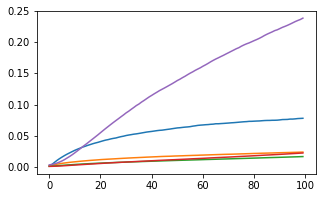

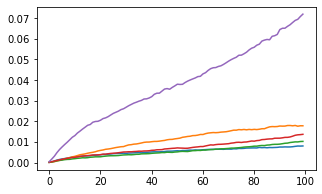

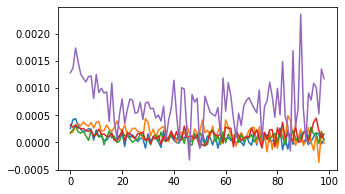

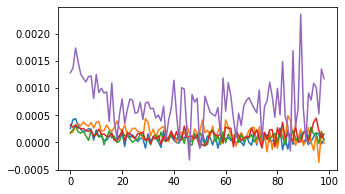

In [10]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        sumss_w, sumss_b = 0, 0
        for sks in range(3):
            sumss_w = sumss_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][0] 
            sumss_b = sumss_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][1]

        sumss_w = sumss_w/3
        sumss_b = sumss_b/3

        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var( sumss_w ))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var( sumss_b ))
        
        

for layer_index in num_layers_list:
    for tmp_int in range(len(globals()['var_accumulate_L{}_w'.format(layer_index)])-1):
        minus_w = globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int]
        minus_b = globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int]        
        globals()['var_changes_L{}_w'.format(layer_index)].append( minus_w )
        globals()['var_changes_L{}_b'.format(layer_index)].append( minus_b )
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.036847252, 0.05976881, 0.07997162, 0.09360643, 0.10308298, 0.11001669, 0.11644319, 0.12101299, 0.12594832, 0.13052937, 0.13423163, 0.13787556, 0.14070755, 0.14392176, 0.14596334, 0.14844744, 0.15091844, 0.1533534, 0.1553852, 0.15735282, 0.1599303, 0.16231073, 0.1638316, 0.16600646, 0.16773255, 0.1697036, 0.17062643, 0.17246383, 0.17422278, 0.17545387, 0.17692603, 0.17806976, 0.17915422, 0.18044458, 0.18156041, 0.18231525, 0.18299979, 0.18466993, 0.18565902, 0.18658598, 0.1877812, 0.18873014, 0.18939131, 0.19018142, 0.19111054, 0.1920692, 0.19328152, 0.19352143, 0.19443539, 0.19559519, 0.19657181, 0.19664894, 0.19788611, 0.19840343, 0.19888707, 0.1994887, 0.20053898, 0.20159036, 0.20205183, 0.20255733, 0.2030542, 0.20366746, 0.20428246, 0.20486127, 0.20549265, 0.20598033, 0.20607042, 0.20635983, 0.2065409, 0.20694035, 0.20724434, 0.20760483, 0.20828961, 0.208542

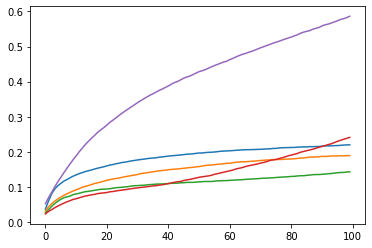

In [11]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch-1):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

[[0.8230000138282776, 0.8360000252723694, 0.8270000219345093, 0.8180000185966492, 0.8140000104904175, 0.8360000252723694, 0.8080000281333923, 0.8080000281333923, 0.8579999804496765, 0.828000009059906], [0.8289999961853027, 0.8140000104904175, 0.8379999995231628, 0.7870000004768372, 0.8240000009536743, 0.8240000009536743, 0.8169999718666077, 0.7900000214576721, 0.8109999895095825, 0.8040000200271606], [0.8309999704360962, 0.8339999914169312, 0.8529999852180481, 0.8169999718666077, 0.8159999847412109, 0.8600000143051147, 0.8299999833106995, 0.8199999928474426, 0.8240000009536743, 0.8230000138282776], [0.8619999885559082, 0.824999988079071, 0.8740000128746033, 0.859000027179718, 0.8489999771118164, 0.8230000138282776, 0.8519999980926514, 0.8339999914169312, 0.8220000267028809, 0.8360000252723694], [0.8849999904632568, 0.8270000219345093, 0.8700000047683716, 0.8500000238418579, 0.8569999933242798, 0.8519999980926514, 0.8579999804496765, 0.828000009059906, 0.847000002861023, 0.8700000047683

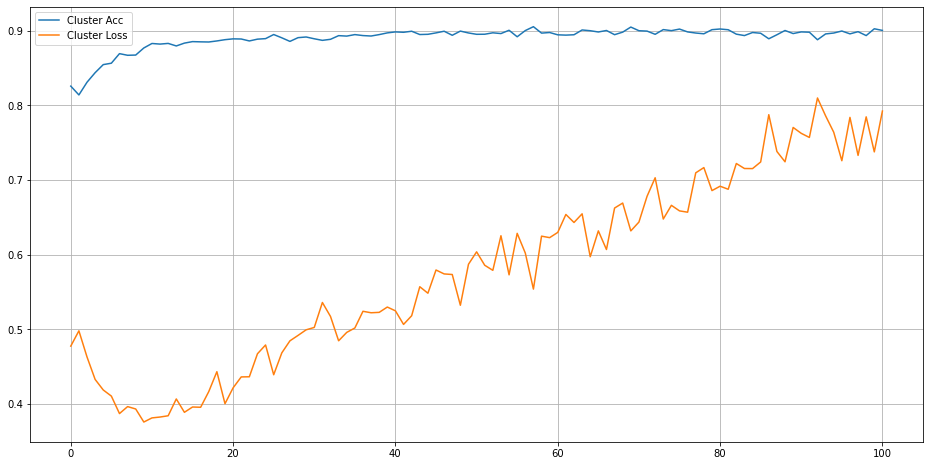

In [12]:
average_acc_cluster_list, average_loss_cluster_list = [], []


for i in range(len(Cluster_ACC)):    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    
plt.figure(figsize=(16,8))
plt.plot(average_acc_cluster_list, label='Cluster Acc')
print(Cluster_ACC)
print(Cluster_LOSS,"\n\n\n")
plt.plot(average_loss_cluster_list, label='Cluster Loss')

plt.grid(True)
plt.legend()
plt.show()
